In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint
# Зняти всі обмеження на вивід у Jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0) 
colors = ['#4682B4', '#FF6347']

# Analytics Report on A/B testing Facebook Advertising Campaigns

## Вступ
**ПРОДУКТ**: Мобільний застосунок. Тестуємо два екрани з підпискою.   
**МЕТА тесту**: підняти конверсію в підписку з 17% до 20%.   
**ГІПОТЕЗИ**:   
    - Нульова гіпотеза (H0): Новий екран підписки з інформацією про знижку не змінює конверсію у підписку.   
    - Альтернативна гіпотеза (H1): Новий екран з пропозицією знижки збільшує конверсію у підписку.   
**КОРИСТУВАЧІ**: Нові користувачів, які щойно встановили застосунок, пройшли онбординг і побачили екран з підпискою.   
**ГРУПИ**:   
    - Контрольна група (А) — бачить поточний екран з пропозицією купити підписку за $4.99, щоб отримати доступ до преміум-функцій застосунку.    
    - Експериментальна група (B) — бачить екран з пропозицією тієї ж підписки, але з припискою про те, що це пропозиція зі знижкою 50%.   
**ЦІЛЬОВА МЕТРИКА**: Конверсія в підписку на екрані пропозиції.   
**ДОПОМІЖНІ МЕТРИКИ**:   
    - Дохід з користувача, що бачив екран (ARPU).   
    - Кількість кліків на кнопку "Купити підписку".    
    - Retention rate Day1/Day7.   
**АЛЬФА** (ймовірність помилки I роду) α : 0.05 (95% Confidence level).   
**БЕТА** (ймовірність помилки II роду) β: 0.20 (80% Power Level).   
**ТИП ТЕСТУ**: Односторонній (конверсія в контрольній групі А менша за конверсію в експериментальній групі В).   

## Introduction
**PRODUCT**: Mobile application. We are testing two versions of a subscription screen.   
**TEST GOAL**: Increase the subscription conversion rate from 17% to 20%.   
**HYPOTHESES**:   
    - Null Hypothesis (H0): The new subscription screen with a discount message does not affect the subscription conversion rate.   
    - Alternative Hypothesis (H1): The new screen with a discount message increases the subscription conversion rate.   
**USERS**: New users who have just installed the app, completed onboarding, and reached the subscription offer screen.      
**GROUPS**:   
    - Control Group (A) — sees the current screen offering a subscription for $4.99 to access premium app features.   
    - Test Group (B) — sees a screen offering the same subscription, but with a note indicating it’s a 50% discount offer.   
**PRIMARY METRIC**: Subscription conversion rate on the offer screen.   
**SECONDARY METRICS**:   
    - Revenue per user who saw the screen (ARPU).   
    - Number of clicks on the "Buy Subscription" button.   
    - Retention rate Day 1 / Day 7.   
**ALPHA** (Type I error rate):α 0.05 (95% Confidence Level).   
**BETA** (Type II error rate) β: 0.20 (80% Power Level).   
**TEST TYPE**: One-tailed (we expect the conversion rate in the control group A to be lower than in the test group B).

In [2]:
df_init= pd.read_csv('C:/Users/yarem/Downloads/ab_test_data.csv')
df_init.head(10)

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0
5,0c6aad3a-8068-473c-98ea-88abbcacbe67,2023-07-15 21:13:55.067827,b,0
6,397c76e4-a4db-4712-b3ce-febfb13cb634,2023-07-18 07:03:05.315509,b,0
7,9b1f084d-8a7f-4526-b859-4935ca99482c,2023-07-17 12:11:21.902593,a,0
8,37ade847-cd45-4ca7-99c6-13fe881e7f42,2023-07-24 23:35:24.243933,b,0
9,b856113a-75d4-4911-894c-4d4c75f37c34,2023-07-22 19:38:24.460128,a,0


In [3]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     19998 non-null  object
 1   timestamp   19998 non-null  object
 2   test_group  19998 non-null  object
 3   conversion  19998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


In [4]:
df_init.groupby('test_group').describe()

conversion                                             
                count      mean       std  min  25%  50%  75%  max
test_group                                                        
a             10013.0  0.061021  0.239380  0.0  0.0  0.0  0.0  1.0
b              9985.0  0.089034  0.284806  0.0  0.0  0.0  0.0  1.0

In [5]:
df=df_init.copy()

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [7]:
info_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.notnull().sum().values,
    'Null Count': df.isnull().sum().values,
    'Unique Values': [df[col].nunique() for col in df.columns],
    'Sample Value': [df[col].dropna().iloc[0] if not df[col].dropna().empty else None for col in df.columns],
    'Min': [df[col].min() if pd.api.types.is_numeric_dtype(df[col]) or pd.api.types.is_datetime64_any_dtype(df[col]) else None for col in df.columns],
    'Max': [df[col].max() if pd.api.types.is_numeric_dtype(df[col]) or pd.api.types.is_datetime64_any_dtype(df[col]) else None for col in df.columns]
})

info_df

,Column,Data Type,Non-Null Count,Null Count,Unique Values,Sample Value,Min,Max
0,user_id,object,19998,0,19998,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,None,None
1,timestamp,datetime64[ns],19998,0,19998,2023-07-04 04:40:55.848109,2023-07-03 01:42:34.033708,2023-07-25 01:41:19.152664
2,test_group,object,19998,0,2,a,None,None
3,conversion,int64,19998,0,2,0,0,1


## Загальна інформація про дані
- Кількість рядків: 19998
- Кількість стовпців: 4
- Типи даних: числові (int), категоріальні (object)  
**Висновки:**
Загальна кількість записів 19998. Нульові значення вітсутні.

## General Data Overview
- Number of rows: 19998
- Number of columns: 4
- Data types: numerical (int), categorical (object)  
**Conclusions:**
The total number of records is 19,998. There are no missing (null) values.

In [8]:
# Кількість унікальних користувачів у всій вибірці
respondents = df['user_id'].nunique()

#Групи
group_a = df[df['test_group'] == 'a']
group_b = df[df['test_group'] == 'b']

# Унікальні користувачі в кожній групі
unique_a = group_a['user_id'].nunique()
unique_b = group_b['user_id'].nunique()

# Кількість конверсій
conv_a = group_a['conversion'].sum()
conv_b = group_b['conversion'].sum()

# Рівень конверсії
p_a = conv_a / unique_a
p_b = conv_b / unique_b
cr_a = round(p_a * 100, 1)
cr_b = round(p_b * 100, 1)

# Дата початку і кінця тесту
start_date = df['timestamp'].min().date()
end_date = df['timestamp'].max().date()
duration_days = (end_date - start_date).days

# Рівень значущості (alpha) для 95% довірчого інтервалу
alpha = 0.05

# Довірчий інтервал для рівня конверсії групи A (метод Вілсона)
conf_int_a_lower, conf_int_a_upper = proportion_confint(conv_a, unique_a, alpha=alpha, method='wilson')
conf_int_a_lower_pct = round(conf_int_a_lower * 100, 1)
conf_int_a_upper_pct = round(conf_int_a_upper * 100, 1)

# Довірчий інтервал для рівня конверсії групи B (метод Вілсона)
conf_int_b_lower, conf_int_b_upper = proportion_confint(conv_b, unique_b, alpha=alpha, method='wilson')
conf_int_b_lower_pct = round(conf_int_b_lower * 100, 1)
conf_int_b_upper_pct = round(conf_int_b_upper * 100, 1)

# РОЗРАХУНОК ДОВІРЧОГО ІНТЕРВАЛУ ДЛЯ РІЗНИЦІ ПРОПОРЦІЙ (CR_A - CR_B) для ОДНОСТОРОННЬОГО ТЕСТУ

# Обчислення спостережуваної різниці конверсій
diff_cr_raw = p_b - p_a

# Обчислення стандартної похибки для різниці пропорцій
se_diff = np.sqrt((p_a * (1 - p_a) / unique_a) + (p_b * (1 - p_b) / unique_b))

# Критичне значення Z для 95% довірчого інтервалу для ОДНОСТОРОННЬОГО тесту
z_score_one_sided = stats.norm.ppf(1 - alpha)

# Межа похибки для різниці
margin_of_error_diff = z_score_one_sided * se_diff

# Довірчий інтервал для різниці 
conf_int_diff_lower_raw = diff_cr_raw - margin_of_error_diff
conf_int_diff_upper_raw = diff_cr_raw + margin_of_error_diff
conf_int_diff_lower=round(conf_int_diff_lower_raw, 2) 
conf_int_diff_lower_pct = round(conf_int_diff_lower_raw * 100, 1)
conf_int_diff_upper_pct = round(conf_int_diff_upper_raw * 100, 1)

In [9]:
Markdown(f"""
## У дослідженні взяли участь **{respondents:,}** унікальних респондентів.      
- група A: **{unique_a}** користувачів       
- група В: **{unique_b}** користувачів.     
""")


## У дослідженні взяли участь **19,998** унікальних респондентів.      
- група A: **10013** користувачів       
- група В: **9985** користувачів.     


In [10]:
Markdown(f"""
## A total of {respondents:,} unique respondents participated in the experiment.
- Group A: **{unique_a}** users
- Group B: **{unique_b}** users.
""")


## A total of 19,998 unique respondents participated in the experiment.
- Group A: **10013** users
- Group B: **9985** users.


In [11]:
conversion_counts = df.groupby('test_group')['conversion'].sum().reset_index()

In [12]:
Markdown(f"""
## Кількість конверсій складає:   
- група A: **{conv_a}**          
- група В: **{conv_b}**   
""")


## Кількість конверсій складає:   
- група A: **611**          
- група В: **889**   


In [13]:
Markdown(f"""
## The number of conversions is:   
- Group A: **{conv_a}**          
- Group В: **{conv_b}**   
""")


## The number of conversions is:   
- Group A: **611**          
- Group В: **889**   


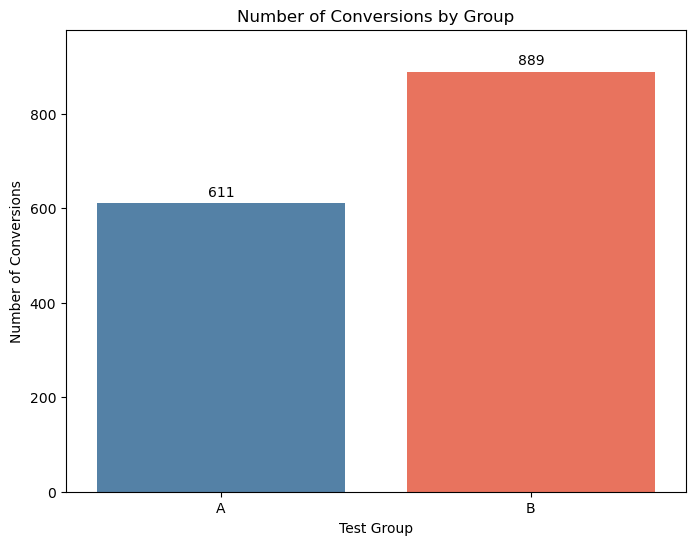

In [14]:
conversion_counts['test_group'] = conversion_counts['test_group'].str.upper()
plt.figure(figsize=(8, 6), dpi=100)

ax = sns.barplot(data=conversion_counts, x='test_group', y='conversion', hue='test_group', palette=colors, legend=False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=10)

ax.set_ylim(0, conversion_counts['conversion'].max() * 1.1)

plt.title('Number of Conversions by Group')
plt.xlabel('Test Group')
plt.ylabel('Number of Conversions')

plt.show()

In [15]:
conversion_data = df.groupby('test_group').agg(conversions=('conversion', 'sum'), total=('conversion', 'count')).reset_index()

In [16]:
Markdown(f""" 
## Рівень конверсії:   
- група A: **{cr_a }%**         
- група В: **{cr_b}%**   
""")

 
## Рівень конверсії:   
- група A: **6.1%**         
- група В: **8.9%**   


In [17]:
Markdown(f""" 
## The conversion rate is:   
- Group A: **{cr_a }%**         
- Group В: **{cr_b}%**   
""")

 
## The conversion rate is:   
- Group A: **6.1%**         
- Group В: **8.9%**   


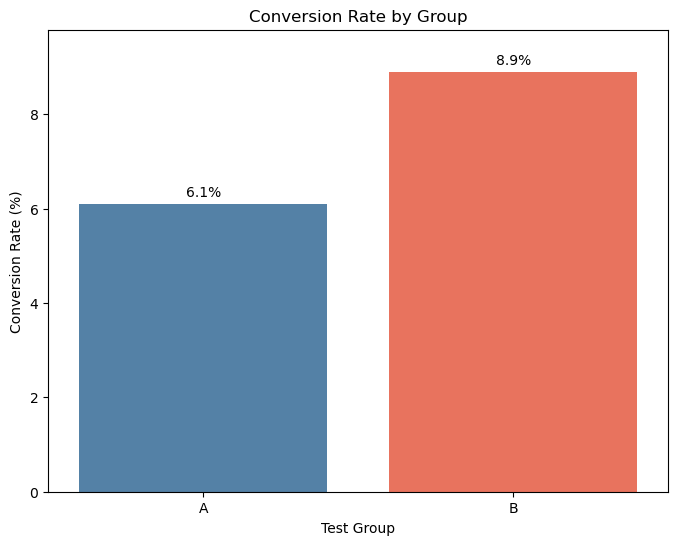

In [18]:
conversion_data['conversion_rate'] = (conversion_data['conversions'] / conversion_data['total']) * 100
conversion_data['test_group'] = conversion_data['test_group'].str.upper()

plt.figure(figsize=(8, 6), dpi=100)

ax = sns.barplot(data=conversion_data, x='test_group', y='conversion_rate', hue='test_group', palette=colors, legend=False)

# Додавання міток з відсотками (округлено до 2 знаків)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=10)

# Налаштування меж осі Y для додаткового простору
ax.set_ylim(0, conversion_data['conversion_rate'].max() * 1.1)

plt.title('Conversion Rate by Group')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate (%)')

plt.show()

In [19]:
conversion_time = df.groupby([pd.Grouper(key='timestamp', freq='D'), 'test_group']).agg(conversions=('conversion', 'sum'), total=('conversion', 'count')).reset_index()

In [20]:
Markdown(f"""
## Тривалість тесту: {duration_days} дні
- Дата початку: **{start_date}**
- Дата завершення: **{end_date}**
""")


## Тривалість тесту: 22 дні
- Дата початку: **2023-07-03**
- Дата завершення: **2023-07-25**


In [21]:
Markdown(f"""
## Test duration: **{duration_days}** days
- Start date: **{start_date}**  
- End date: **{end_date}**
""")


## Test duration: **22** days
- Start date: **2023-07-03**  
- End date: **2023-07-25**


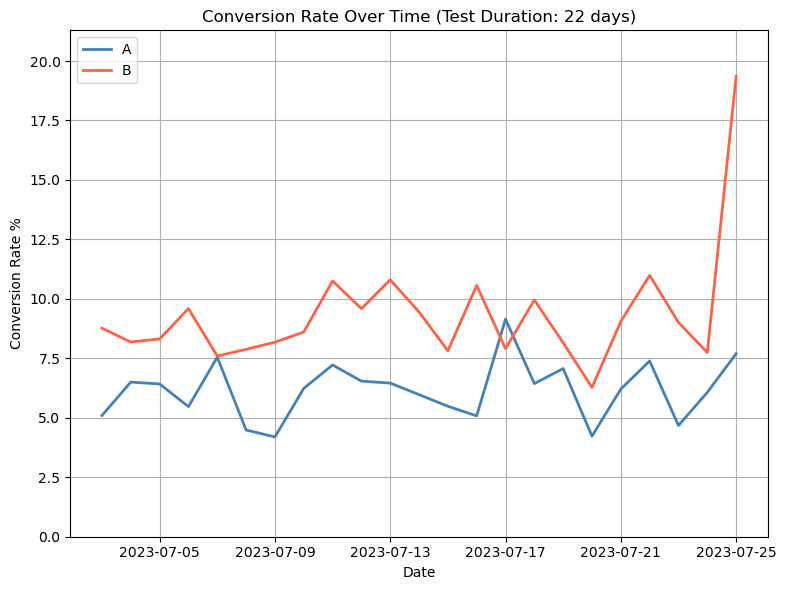

In [22]:
conversion_time['conversion_rate'] = (conversion_time['conversions'] / conversion_time['total']) * 100
conversion_time['test_group'] = conversion_time['test_group'].str.upper()

plt.figure(figsize=(8, 6), dpi=100)

sns.lineplot(data=conversion_time, x='timestamp', y='conversion_rate', linewidth=2, hue='test_group', palette=colors)

plt.title(f'Conversion Rate Over Time (Test Duration: {duration_days} days)')
plt.xlabel('Date')
plt.ylabel('Conversion Rate %')

plt.ylim(0, conversion_time['conversion_rate'].max() * 1.1)
plt.legend(title=None) 
plt.tight_layout()
plt.grid(True)
plt.show()

Відповідно до показників графіку, що відображє зміни конверсії в часі спострерігаємо вищий рівень конверсії в експериментальній групі В порівняно з рівнем конверсії контрольної групи А протягом всього періоду тестування та значне її підвищення в останній день тесту.

According to the conversion-rate-over-time chart, we observe a consistently higher conversion rate in the experimental group B compared to the control group A throughout the entire test period, with a significant increase on the final day of the experiment.

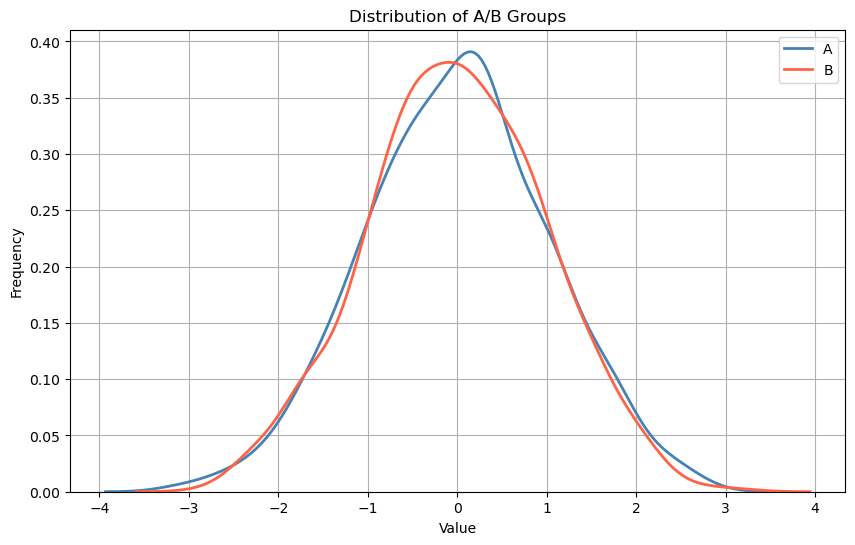

In [23]:
plt.figure(figsize=(10, 6))

sns.kdeplot(stats.norm.rvs(size=1000), color=colors[0], linewidth=2)
sns.kdeplot(stats.norm.rvs(size=1000), color=colors[1], linewidth=2)

plt.title('Distribution of A/B Groups')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.legend(['A', 'B'])

plt.grid(True)
plt.show()

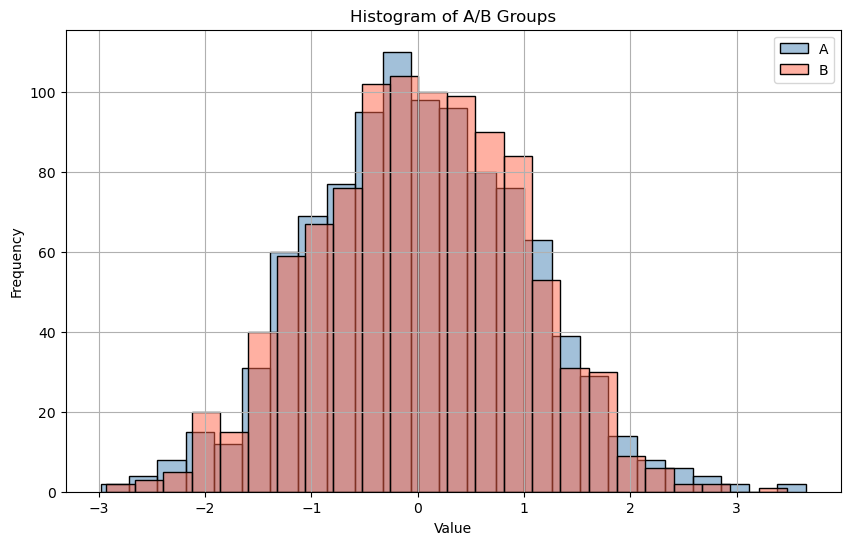

In [24]:
plt.figure(figsize=(10, 6))

sns.histplot(stats.norm.rvs(size=1000), color=colors[0], alpha=0.5)
sns.histplot(stats.norm.rvs(size=1000), color=colors[1], alpha=0.5)

plt.title('Histogram of A/B Groups')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.legend(['A', 'B'])
plt.grid(True)
plt.show()

Оскільки розподіл даних, отриманих під час тесту наближений до нормального обираємо для аналізу Критерій Стʼюдента.

Since the data distribution obtained during the test is approximately normal, we choose the Student's t-test for the analysis.

## Тестування гіпотез за Критерієм Стʼюдента (Student's t-test)

In [25]:
alpha = 0.05

statistic, pvalue = stats.ttest_ind(df[df['test_group'] == 'a']['conversion'],
                                   df[df['test_group'] == 'b']['conversion'], 
                                    equal_var=False,
                                    alternative='less')

print(f't-statistic: {round(statistic, 2)}, p-value: {round(pvalue, 2)}')

if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

t-statistic: -7.53, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


Абсолютна величина t-statistic (7.53) є  високою, що вказує на суттєву різницю між середніми значеннями груп відносно варіабельності всередині груп.    
Негативний знак (-7.53) прямо вказує, що середній коефіцієнт конверсії Групи A нижчий, ніж середній коефіцієнт конверсії Групи B.   
Р-value (0.0) є меншим встановленого рівня alpha (0.05), що дозволяє відхилити нульову гіпотезу.

The absolute value of the t-statistic (7.53) is high, indicating a significant difference between the group means relative to the variability within the groups.   
The negative sign (-7.53) directly indicates that the average conversion rate of Group A is lower than the average conversion rate of Group B.   
The p-value (0.0) is less than the established alpha level (0.05), which allows us to reject the null hypothesis.

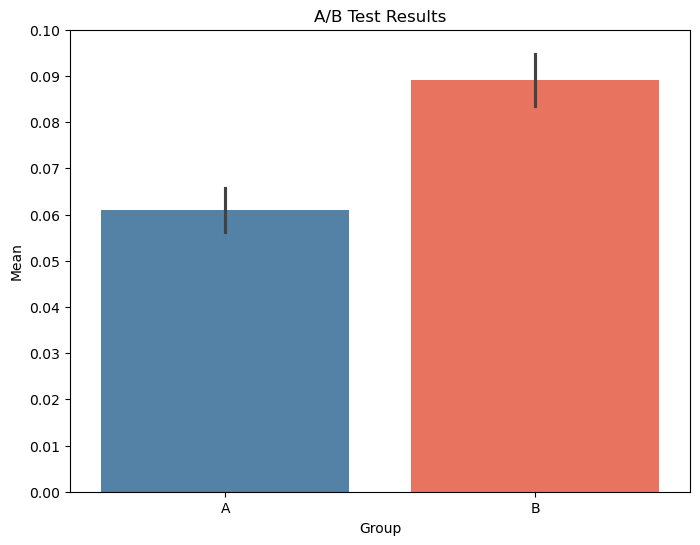

In [26]:
df['test_group'] = df['test_group'].str.upper()
plt.figure(figsize=(8, 6))
sns.barplot(
    x='test_group',
    y='conversion',
    data=df,
    hue='test_group',       
    palette=colors,
    errorbar=('ci', 95),
    legend=False            
)
plt.yticks(np.arange(0, 0.11, 0.01))
plt.title('A/B Test Results')
plt.xlabel('Group')
plt.ylabel('Mean')

plt.show()

In [32]:
 Markdown(f""" 
Відповідно до візуалізації порівняння середніх значень у групах з 95% довірчими інтервалами рівень конверсії в групах:  
- Група A має конверсію **{cr_a }%** , α 95% CI = [{conf_int_a_lower_pct}%, {conf_int_a_upper_pct}%]         
- Група B має конверсію **{cr_b }%** , α 95% CI = [{conf_int_b_lower_pct}%, {conf_int_b_upper_pct}%]    
Довірчі інтервали (CI) груп A і B не перекриваються, тобто діапазони, в яких з імовірністю 95% знаходяться справжні значення конверсії обох груп, не мають спільних значень.
""")

 
Відповідно до візуалізації порівняння середніх значень у групах з 95% довірчими інтервалами рівень конверсії в групах:  
- Група A має конверсію **6.1%** , α 95% CI = [5.6%, 6.6%]         
- Група B має конверсію **8.9%** , α 95% CI = [8.4%, 9.5%]    
Довірчі інтервали (CI) груп A і B не перекриваються, тобто діапазони, в яких з імовірністю 95% знаходяться справжні значення конверсії обох груп, не мають спільних значень.


In [31]:
 Markdown(f""" 
According to the visualization comparing mean values in groups with 95% confidence intervals, the conversion rate in the groups:
- Group A has a conversion of {cr_a}%, α 95% CI = [{conf_int_a_lower_pct}%, {conf_int_a_upper_pct}%]
- Group B has a conversion of {cr_b}%, α 95% CI = [{conf_int_b_lower_pct}%, {conf_int_b_upper_pct}%]   
The confidence intervals (CI) for groups A and B do not overlap, meaning the ranges within which the true conversion values for both groups lie with 95% probability have no common values.
""")

 
According to the visualization comparing mean values in groups with 95% confidence intervals, the conversion rate in the groups:
- Group A has a conversion of 6.1%, α 95% CI = [5.6%, 6.6%]
- Group B has a conversion of 8.9%, α 95% CI = [8.4%, 9.5%]   
The confidence intervals (CI) for groups A and B do not overlap, meaning the ranges within which the true conversion values for both groups lie with 95% probability have no common values.


In [30]:
 Markdown(f""" 
Розрахунок довірчого інтервалу для різниці пропорцій показує діапазон значень, в якому знаходиться різниця між конверсіями двох груп.   
Отримана нижня межа довірчого інтервалу **{conf_int_diff_lower}** > 0, що свідчить про статистично значущу різницю між Групою B та Групою A.     
Оскільки вона є також позитивною, це означає, що конверсія в Групі B статистично значуще вища, ніж у Групі A.    
З 95% впевненістю можна сказати, що перевага конверсії Групи B над Групою A становить щонайменше на **{conf_int_diff_lower_pct}%** та не перевищує **{conf_int_diff_upper_pct}%**.
""")

 
Розрахунок довірчого інтервалу для різниці пропорцій показує діапазон значень, в якому знаходиться різниця між конверсіями двох груп.   
Отримана нижня межа довірчого інтервалу **0.02** > 0, що свідчить про статистично значущу різницю між Групою B та Групою A.     
Оскільки вона є також позитивною, це означає, що конверсія в Групі B статистично значуще вища, ніж у Групі A.    
З 95% впевненістю можна сказати, що перевага конверсії Групи B над Групою A становить щонайменше на **2.2%** та не перевищує **3.4%**.


In [33]:
 Markdown(f""" 
The calculation of the confidence interval for the difference in proportions shows the range of values within which the difference between the conversions of the two groups lies.   
The obtained lower bound of the confidence interval {conf_int_diff_lower} > 0, which indicates a statistically significant difference between Group B and Group A.   
As it is also positive, this means that the conversion in Group B is statistically significantly higher than in Group A.   
With 95% confidence, it can be stated that the conversion advantage of Group B over Group A is at least {conf_int_diff_lower_pct}% and does not exceed {conf_int_diff_upper_pct}%.
""")

 
The calculation of the confidence interval for the difference in proportions shows the range of values within which the difference between the conversions of the two groups lies.   
The obtained lower bound of the confidence interval 0.02 > 0, which indicates a statistically significant difference between Group B and Group A.   
As it is also positive, this means that the conversion in Group B is statistically significantly higher than in Group A.   
With 95% confidence, it can be stated that the conversion advantage of Group B over Group A is at least 2.2% and does not exceed 3.4%.


# Висновки

- Оскільки додаткові метрики не зазнали значних змін, аналіз тесту проводився відповідно до показників цільової метрики - конверсії з онбордингу в платіж.   
- Результати t-statistic дозволяють відхилити нульову гіпотезу та вказують, що середній коефіцієнт конверсії Групи A є статистично значущо нижчим за середній коефіцієнт конверсії Групи B. 
- Ці результати підтверджуються також розбіжністю показників довірчих інтервалів груп, які свідчать про те, що значення конверсії обох груп не мають спільних значень. 
- Відповідно до розрахунку довірчого інтервалу для різниці пропорцій перевага конверсії Групи B над Групою A становить щонайменше на 2.2% та не перевищує 3.4%.   
## **Рекомендації:**     
- Впроваджуємо новий екран з підпискою на 100% нових користувачів.
- Продовжуємо відслідковувати основну та додаткові метрики (ARPU, Retention, Сhurn).
- Відповідно до показників графіку, що відображє зміни конверсії в часі спострерігаємо значне підвищення рівня конверсії в останній день тесту, що потребує додатково вивчення на предмет можливих причин такого явища.

# Conclusions
- Since the additional metrics showed no significant changes, the test analysis focused primarily on the target metric: conversion from onboarding to payment.   
- The t-statistic results allowed us to reject the null hypothesis, indicating that Group A's average conversion rate is statistically significantly lower than Group B's. This means Group B performed better.   
- These findings are further supported by the non-overlapping confidence intervals of the individual groups, confirming that their true conversion values do not share a common range.
- Based on the confidence interval calculation for the difference in proportions, Group B's conversion advantage over Group A is at least 2.2% and does not exceed 3.4%.   
## **Recomendations:**
- Implement the new subscription screen for 100% of new users.
- Continue to monitor key and additional metrics, including ARPU (Average Revenue Per User), Retention, and Churn, to track long-term impact.
- Investigate the significant increase in conversion observed on the last day of the test as shown on the conversion over time graph. This spike requires additional study to understand its potential causes.